In [4]:
# === Cell 1: Setup ===
!pip install datasets evaluate accelerate torch torchaudio torchcodec
!pip install --upgrade transformers

import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

from datasets import load_dataset, Audio
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
from collections import Counter


GPU available: True
GPU name: Tesla T4


In [5]:
# Load dataset
ds = load_dataset("stillerman/libristutter-4.7k")
ds = ds.cast_column("audio", Audio(sampling_rate=16000))

# Add binary stutter label
def add_stutter_label(example):
    example["stutter_label"] = int("[STUTTER]" in example["text"])
    return example

ds = ds.map(add_stutter_label)

print("Features:", ds["train"].features)
print("Train distribution:", Counter(ds["train"]["stutter_label"]))
print("Test distribution:", Counter(ds["test"]["stutter_label"]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Features: {'name': Value('string'), 'audio': Audio(sampling_rate=16000, decode=True, stream_index=None), 'text': Value('string'), 'stutter_label': Value('int64')}
Train distribution: Counter({1: 3214, 0: 1048})
Test distribution: Counter({1: 351, 0: 123})


In [6]:
# === Cell 3: Preprocessing and Encoding ===
from transformers import Wav2Vec2Processor

# Use processor (feature extractor + tokenizer wrapper)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

def preprocess(batch):
    # Grab list of audio arrays when batched=True
    audio_arrays = [a["array"] for a in batch["audio"]]

    # Process with padding
    inputs = processor(
        audio_arrays,
        sampling_rate=16000,
        padding=True,           # ensures same length
        return_tensors="np"     # keep as numpy before collator
    )

    # Attach labels
    inputs["labels"] = batch["stutter_label"]
    return inputs

# Encode dataset
ds_encoded = ds.map(
    preprocess,
    remove_columns=["audio", "text", "name"],
    batched=True,
    batch_size=8               # smaller batch for testing
)

print("Encoded features:", ds_encoded["train"].features)
print("Example batch keys:", ds_encoded["train"][0].keys())


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Encoded features: {'stutter_label': Value('int64'), 'input_values': List(Value('float32')), 'labels': Value('int64')}
Example batch keys: dict_keys(['stutter_label', 'input_values', 'labels'])


In [7]:
# === Cell 4: Model, Collator, and Metrics ===
from transformers import Wav2Vec2ForSequenceClassification, DataCollatorWithPadding
import evaluate

# Define model
num_labels = 2
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_labels,
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=processor, padding=True)

# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# === Cell 5: Training Setup (Manual Early Stopping Ready) ===
from transformers import TrainingArguments, Trainer
import os

# 🚫 Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# 🔀 Split 10% of train into validation
split_ds = ds_encoded["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = split_ds["train"]
val_dataset = split_ds["test"]

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(ds_encoded['test'])}")

# ⚠️ set 1 epoch here (we'll loop manually in Cell 6)
training_args = TrainingArguments(
    output_dir="./stutter-checkpoints",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,       # run only 1 epoch at a time
    logging_steps=10,
    save_total_limit=1,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Train size: 3835, Validation size: 427, Test size: 474


/tmp/ipython-input-752581892.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# === Cell 6: Train with Manual Early Stopping (4 Epochs, patience=2) ===
import numpy as np

best_f1 = 0.0
patience = 2   # ⏳ stop only after 2 epochs with no improvement
wait = 0

# resume from checkpoint if available
last_checkpoint = None
if os.path.isdir("./stutter-checkpoints"):
    checkpoints = [d for d in os.listdir("./stutter-checkpoints") if d.startswith("checkpoint")]
    if checkpoints:
        last_checkpoint = os.path.join("./stutter-checkpoints", sorted(checkpoints)[-1])
        print(f"🔄 Resuming from: {last_checkpoint}")

for epoch in range(4):   # 🔄 max 4 epochs
    print(f"\n🚀 Starting epoch {epoch+1}/4")

    trainer.train(resume_from_checkpoint=last_checkpoint)

    # 📊 evaluate on validation
    val_metrics = trainer.evaluate(val_dataset)
    print(f"Validation metrics after epoch {epoch+1}: {val_metrics}")

    # 🔎 check early stopping (using F1)
    current_f1 = val_metrics["eval_f1"]
    if current_f1 > best_f1:
        best_f1 = current_f1
        wait = 0
        print("✅ Improvement detected, keeping model.")
        trainer.save_model("./stutter-best-model")
        processor.save_pretrained("./stutter-best-model")
    else:
        wait += 1
        print(f"⚠️ No improvement (wait={wait}/{patience})")
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

    # update checkpoint path for next loop iteration
    if os.path.isdir("./stutter-checkpoints"):
        checkpoints = [d for d in os.listdir("./stutter-checkpoints") if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = os.path.join("./stutter-checkpoints", sorted(checkpoints)[-1])

# 🎯 Final evaluation on test set
print("\nEvaluating on test set...")
test_metrics = trainer.evaluate(ds_encoded["test"])
print("Final Test Results:", test_metrics)


🔄 Resuming from: ./stutter-checkpoints/checkpoint-480

🚀 Starting epoch 1/4


Step,Training Loss


Validation metrics after epoch 1: {'eval_loss': 0.40126878023147583, 'eval_accuracy': 0.8079625292740047, 'eval_f1': 0.7613066595205082, 'eval_runtime': 109.1361, 'eval_samples_per_second': 3.913, 'eval_steps_per_second': 0.495, 'epoch': 1.0}
✅ Improvement detected, keeping model.

🚀 Starting epoch 2/4


Step,Training Loss


Validation metrics after epoch 2: {'eval_loss': 0.40126878023147583, 'eval_accuracy': 0.8079625292740047, 'eval_f1': 0.7613066595205082, 'eval_runtime': 112.542, 'eval_samples_per_second': 3.794, 'eval_steps_per_second': 0.48, 'epoch': 1.0}
⚠️ No improvement (wait=1/2)

🚀 Starting epoch 3/4


Step,Training Loss


Validation metrics after epoch 3: {'eval_loss': 0.40126878023147583, 'eval_accuracy': 0.8079625292740047, 'eval_f1': 0.7613066595205082, 'eval_runtime': 112.6645, 'eval_samples_per_second': 3.79, 'eval_steps_per_second': 0.479, 'epoch': 1.0}
⚠️ No improvement (wait=2/2)
⏹️ Early stopping triggered.

Evaluating on test set...
Final Test Results: {'eval_loss': 0.49921029806137085, 'eval_accuracy': 0.759493670886076, 'eval_f1': 0.686937468009363, 'eval_runtime': 116.6534, 'eval_samples_per_second': 4.063, 'eval_steps_per_second': 0.514, 'epoch': 1.0}


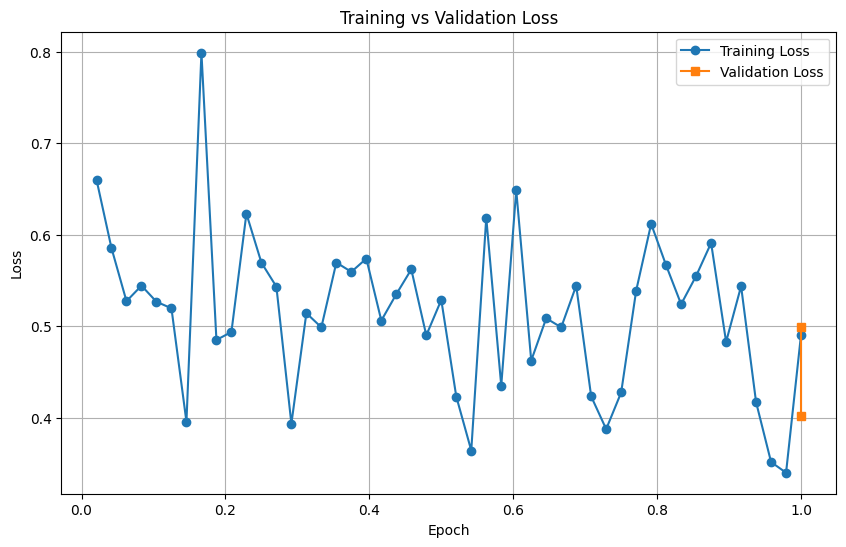

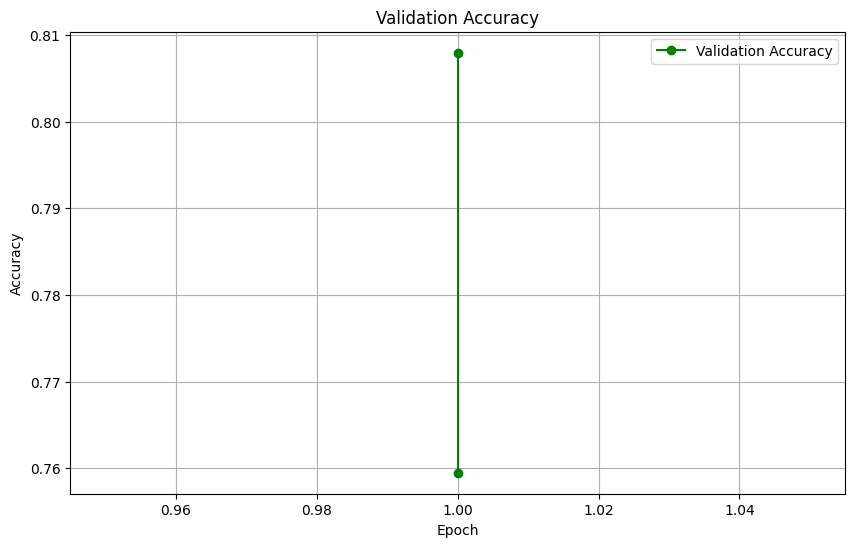

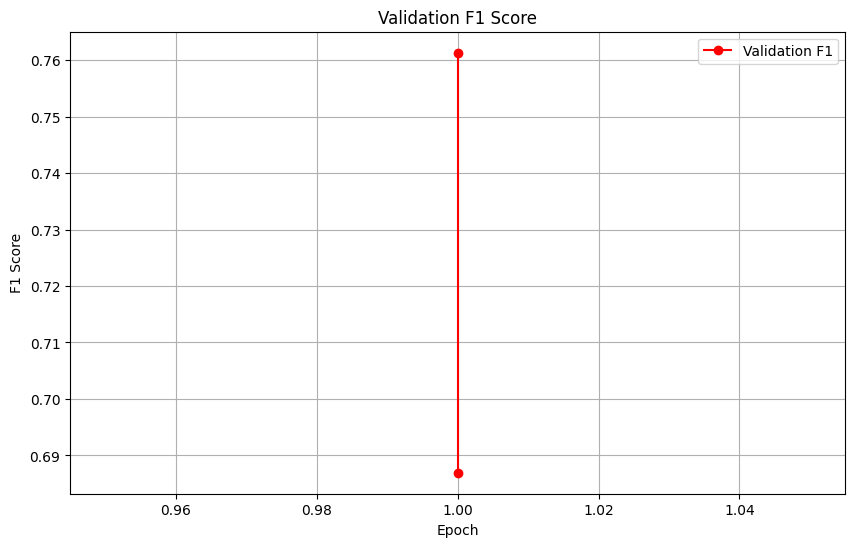

In [19]:
# === Cell 7: Plot Training & Validation Metrics ===
import pandas as pd
import matplotlib.pyplot as plt

# Convert trainer logs into DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# Drop rows without metrics (like saving/checkpoint logs)
log_history = log_history.dropna(subset=["loss", "epoch"], how="all")

# 📉 Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(log_history["epoch"], log_history.get("loss", []), label="Training Loss", marker="o")
plt.plot(log_history["epoch"], log_history.get("eval_loss", []), label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Plot Accuracy
if "eval_accuracy" in log_history.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(log_history["epoch"], log_history["eval_accuracy"], label="Validation Accuracy", marker="o", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# 🎯 Plot F1 Score
if "eval_f1" in log_history.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(log_history["epoch"], log_history["eval_f1"], label="Validation F1", marker="o", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
# === Cell 7: Reload Saved Model and Run Inference ===
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import numpy as np

# 🔄 Load model + processor from disk (no retraining needed)
model = Wav2Vec2ForSequenceClassification.from_pretrained("./stutter-best-model")
processor = Wav2Vec2Processor.from_pretrained("./stutter-best-model")

# 🔮 Run predictions on first 5 test samples
predictions = trainer.predict(ds_encoded["test"].select(range(5)))

pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

for i, (pred, true) in enumerate(zip(pred_labels, true_labels)):
    print(f"\nExample {i+1}:")
    print("Transcript:", ds["test"][i]["text"])
    print("True label:", "stutter" if true == 1 else "no_stutter")
    print("Predicted :", "stutter" if pred == 1 else "no_stutter")



Example 1:
Transcript: though i wanted you to see the teapot to
True label: no_stutter
Predicted : no_stutter

Example 2:
Transcript: i cannot stand i said there is something gone [STUTTER] in my leg and i feel blood running [STUTTER] into my boot he [STUTTER] knelt and rolled down the leg of my stocking with though he only with my foot
True label: stutter
Predicted : stutter

Example 3:
Transcript: [STUTTER] murillo's lips twitched understandingly she had expected message rachel up she had known [STUTTER] that the side of matthew jaunting off so unaccountably would be too much for her neighbors curiosity oh no i'm quite well although i had a bad headache yesterday she said
True label: stutter
Predicted : stutter

Example 4:
Transcript: wherefore their idea also necessarily
True label: no_stutter
Predicted : no_stutter

Example 5:
Transcript: in [STUTTER] the infancy of mowbray by some mill owner not sufficiently prophetic of [STUTTER] the future or sufficiently confident to the energ